# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.

Your company's pricing committee wants your team to estimate energy prices for the next 12-18 months to use those prices as the basis for contract negotiations.

In addition, the VP of strategy is researching investing in storage capacity (i.e., batteries) as a new source of revenue. The plan is to store some of the energy produced by the solar panels when pricing conditions are unfavorable and sell it by the next day on the open market if the prices are higher.

## 💾 The data
You have access to over five years of energy price and demand data ([source](https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia)):

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

In [1]:
import pandas as pd
df = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'])
df.head()

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


## 💪 Competition challenge

Create a report that covers the following:

1. How do energy prices change throughout the year? Are there any patterns by season or month of the year?
2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.
3. Provide guidance on how much revenue the energy storage venture could generate per year using retail prices and a 70MWh storage system.

## 💡 Energy Price 

The Energy price has strong right skew, there is a big difference between 3th quartil and the maximum: the 75% of price's values are below to 95.08 AUD/MWh and the maximum is 4549.65 AUD/MWh. This situation doesn't happen with the lower values, so there isn't left skew.

If it is graphed the energy price you won't see much. Therefore outliers are detected by calculating the upper limit and lower limit using the following formulas:

- $upperLimit = 3thQuartil + 1.5 * interquartilRange$
- $lowerLimit = 1thQuartil - 1.5 * interquartilRange$
- $interquartilRange = 3thQuartil - 1thQuartil$

It is observed that the **upperLimit** [179.63 AUD/MWh] is lower than the maximum [4549.65 AUD/MWh], so all values upper that the upperlimit are *outliers*. The low values of energy's price do not have outliers because the **lowerLimit** [-45.84 AUD/MWh] is lower than the minimum [-6.08 AUD/MWh].

These new information on outliers' presence allows to observe that only 28 [1.33%] from 2106 are outliers.

In [2]:
# Read dataset
import pandas as pd
df = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'])

# Descriptive Statistics
print('Descriptive Statistics for Price of Energy ')
print(round(df[df.price > 0].price.describe(), 2).to_frame())
print('')

# Upper limit and lower limit for detect outliers
interquartil_range = df[df.price > 0].price.describe()['75%'] - df[df.price > 0].price.describe()['25%']
upper_limit = df[df.price > 0].price.describe()['75%'] + 1.5 * interquartil_range
lower_limit = df[df.price > 0].price.describe()['25%'] - 1.5 * interquartil_range

print('upperLimit = ', round(upper_limit, 2))
print('')
print('lowerLimit = ', round(lower_limit,2))
print('')

Descriptive Statistics for Price of Energy 
         price
count  2103.00
mean     76.19
std     130.31
min       6.87
25%      38.83
50%      66.78
75%      95.09
max    4549.65

upperLimit =  179.49

lowerLimit =  -45.58



In [3]:
# Read dataset
import pandas as pd
df = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'])

# Descriptive Statistics
print('Descriptive Statistics for Price of Energy ')
print(round(df.price.describe(), 2).to_frame())
print('')

# Upper limit and lower limit for detect outliers
interquartil_range = df.price.describe()['75%'] - df.price.describe()['25%']
upper_limit = df.price.describe()['75%'] + 1.5 * interquartil_range
lower_limit = df.price.describe()['25%'] - 1.5 * interquartil_range

print('upperLimit = ', round(upper_limit, 2))
print('')
print('lowerLimit = ', round(lower_limit,2))
print('')

# Feature Engineering: outlier_price
df['outlier_price'] = df.price.apply(lambda x: 1 if x > upper_limit else 0)
print('Descriptive Statistics for otulier_price variable')
print(df.outlier_price.value_counts())

Descriptive Statistics for Price of Energy 
         price
count  2106.00
mean     76.08
std     130.25
min      -6.08
25%      38.71
50%      66.60
75%      95.08
max    4549.65

upperLimit =  179.63

lowerLimit =  -45.84

Descriptive Statistics for otulier_price variable
0    2078
1      28
Name: outlier_price, dtype: int64


### Evolution of Energy's Price 🕰

The annual price of energy changes over time. It slowly increases from 2015 to 2016, then strongly increases at 2017, then slowly decreases at 2018, then slowly increases at 2019, finally strongly decreases at 2020. **It is observed to change non-linearly with time, it looks like a parabola**.

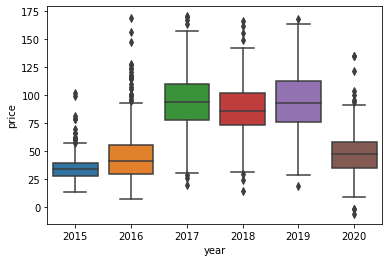

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering: year and month
df['year'] = [ts.year for ts in df.date]

# plot
sns.boxplot(x='year', y='price', data=df[df.price <= 170.63])
plt.show()

The monthly price of energy over the years also changes over time. **It is observed that price is higher in June [month number 6] and July [month number 7] than the rest except at 2015 and 2018**, the median [horizontal line into the boxes] for these months are the highest.

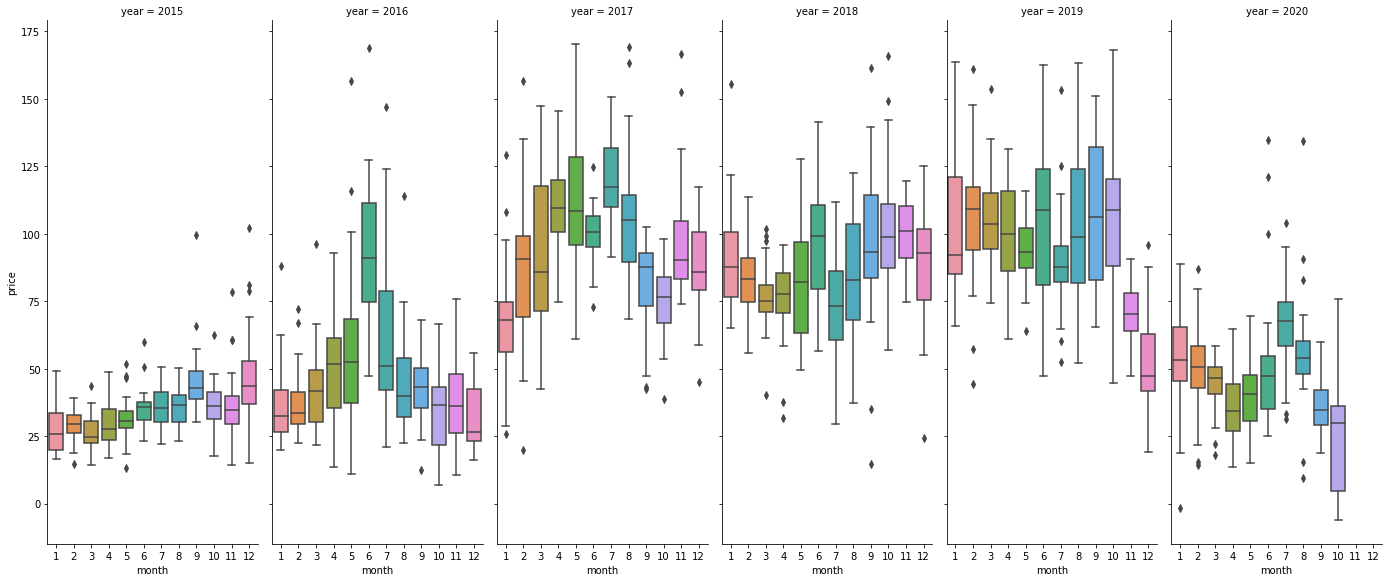

In [5]:
# Feature Engineering: month
df['month'] = [ts.month for ts in df.date]

# plot
sns.catplot(x='month', y='price', col='year', kind='box', data=df[df.price <= 170.63], height=8, aspect=.4)
plt.show()

**The price of energy varies throughout the days of the week**, Saturdays [value equal to 5] and Sundays [value equal to 6] are lower values than the rest of the days of the week, weekend medians are lowest.

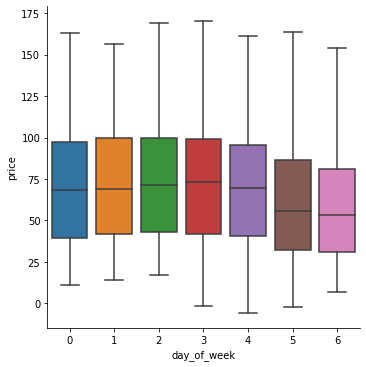

In [6]:
# Feature Engineering: day of week
df['day_of_week'] = [ts.day_of_week for ts in df.date]

# plot
sns.catplot(x='day_of_week', y='price', kind='box', data=df[df.price < 170.63])
plt.show()

In [7]:
df['day_of_year'] = [ts.day_of_year for ts in df.date]
df['week'] = [ts.week for ts in df.date]
df['quarter'] = [ts.quarter for ts in df.date]
df['day'] = [ts.day for ts in df.date]

In [8]:
# Create sequence variable
df['day_sequence'] = [i + 1 for i in range(len(df))]

## Forecast Model for Energy Price

Following Economy theory, the prices of a thing or service are built by its demand and its supply. The energy's price will increase if the demand is greater than the supply and the energy's price will decrease if the demand is less than the supply. In addition, there is a positive relationship between price and demand, so the higher the demand, the higher the price. And there is a negative relationship between price and supply, so the higher the supply, the lower the price.

$$EnergyPrice = F(Demand, Supply)$$

The Demand and Supply depend on many things. For example, Demand could depend of family income, Gross Domestic Product [GDP], Customer Expectations about the Energy Price, Fossil Fuel Prices, Weather Conditions, the variables in the data set, etc. On the other hand Supply depend of Capital Invested in Production, Goverment Spend in Energy Market, Energy Market Regulations, etc. So each one could be a function itself.

Saddenly the dataset does not have variables that play the rol of the Supply. So it is assumed that Supply will be the same accross time. It is a strong assumption but it is necessary in abstractions settings. In futures iterations build a Supply Model getting different variables is a recommendation. So the function to estimate will be:

$$EnergyPrice = F(Demand)$$

As mentioned above, Demand depends of many variables, however in this report it is assumed that Energy Demand depends on variables in the data set associated with weather and variables that can incentivize it, such as like school_day and holiday variables. Then the function that represent the demand will be:

$$ EnergyDemand = Q(minTemperature, maxTemperature, solarExposure, rainfall, schoolDay, holiday) $$

Next, each relationship will be analyzed and all possible models that can be created will be evaluated. Thus, the final Demand Function can change.


Finally, if any weather variable fall within the final variables selected to be part of Demand Function, it will be modelated only with time variables. For example, if min_temperature variable is the only one selected, a new function will be created:

$$ minTemperature = S(date) $$

With all this function, it will create a function that will receive only one date and the output will be the forecasted energy price. Supposing that min_teperature is the only one variable that explain Demand Function the logic of the function that will make the forecast is:


```python
def EnergyPrice(Demand):
    # Code
    return energy_price

def DemandF(minTemperature):
    # Code
    return min_temp

def minTemperature(date):
    # Code
    return demand

def ForecastEnergyPrice(date):
    min_temp = minTemperature(date)
    demand = Demand(min_temp)
    energy_price = EnergyPrice(demand)
    return energy_price
```






### EnergyPrice Function

Let is checked the Relationship between Energy's Price and its Demand. After take the base 10 logarithm positive relationship between price and demand is confirmed. It is also observed that the relationship is not linear, for higher demand's value the price's value increase faster than lower demand's value.

### Plot Price vs Other Variables

In [9]:
df['min_temperature_bins'] = pd.qcut(df.min_temperature, q=4, 
                                  precision=1, labels=False)

In [10]:
df.groupby('min_temperature_bins')['min_temperature'].describe()

,count,mean,std,min,25%,50%,75%,max
min_temperature_bins,,,,,,,,
0,541.0,6.391128,1.646746,0.6,5.30,6.8,7.8,8.5
1,527.0,9.900949,0.785164,8.6,9.25,9.9,10.5,11.3
2,521.0,12.913244,0.938000,11.4,12.10,12.9,13.6,14.6
3,517.0,17.387041,2.206344,14.7,15.70,16.8,18.5,28.0


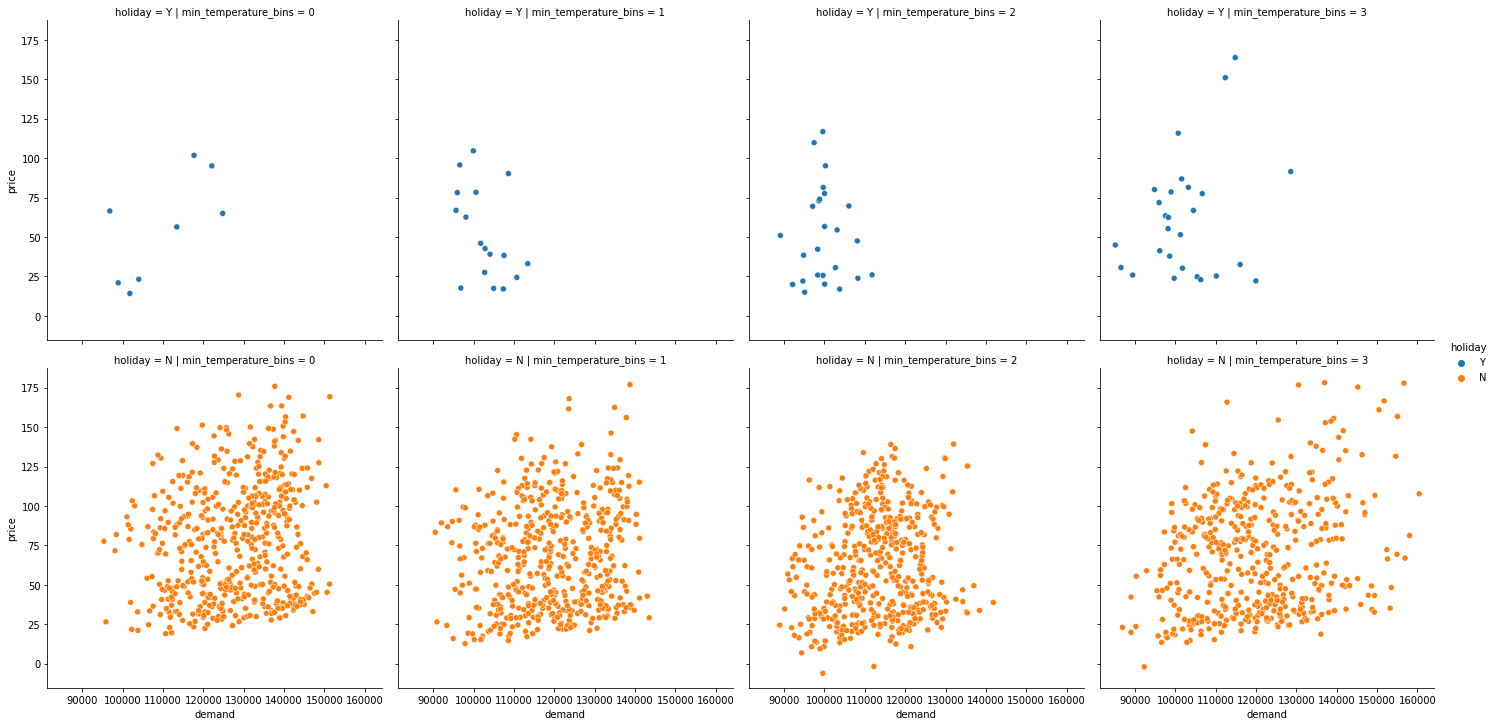

In [11]:
sns.relplot(data=df[df.outlier_price == 0], x='demand', y='price', col='min_temperature_bins', 
            hue='holiday', row='holiday')


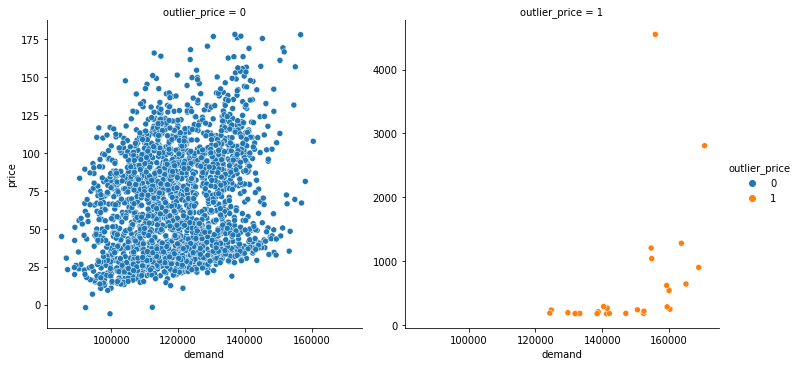

In [12]:
sns.relplot(data=df, x='demand', y='price', col='outlier_price', hue='outlier_price', facet_kws=dict(sharey=False))

### Energy Price Gradient Boosting Regresion

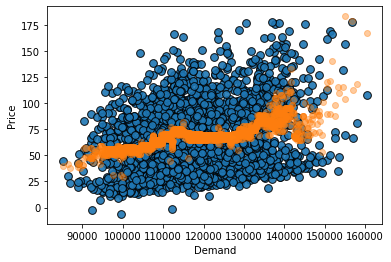

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

# Fit model
# Energy Price Variables
df_PriceModel = df[['price', 'demand', 'week']]

# Remove rows that have at least one missing value
df_PriceModel = df_PriceModel.dropna(axis=0)

PriceModel = GradientBoostingRegressor(random_state=22625)
PriceModel.fit(df_PriceModel[['demand', 'week']], df_PriceModel.price.to_frame())

# Predictions
predictions_PriceModel = PriceModel.predict(df_PriceModel[['demand', 'week']])
df_PriceModel['predictions'] = predictions_PriceModel

# Plot predictions
# Initialize layout
fig, ax = plt.subplots()

# Remove outliers
df_PriceModel = df_PriceModel[df_PriceModel.price <= 179.49]

# Add scatterplot
ax.scatter(df_PriceModel.demand, df_PriceModel.price, s=60, alpha=0.9, edgecolors="k")
#ax.scatter(df.demand.values, y_hat, s=60, alpha=0.2, edgecolors="k")

# Plot regression line
ax.scatter(df_PriceModel.demand, df_PriceModel.predictions, alpha=0.4)
ax.set_xlabel('Demand')
ax.set_ylabel('Price')
plt.show()


## Plot Log10Price vs Log10Demand

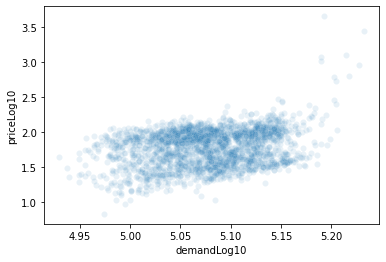

In [14]:
# Apply logarithm to the demand variable
import numpy as np
df['demandLog10'] = np.log10(df.demand)
df['priceLog10'] = np.log10(df.price)

# Plot
sns.scatterplot(data=df, x="demandLog10", y="priceLog10", alpha=0.1)
plt.show()

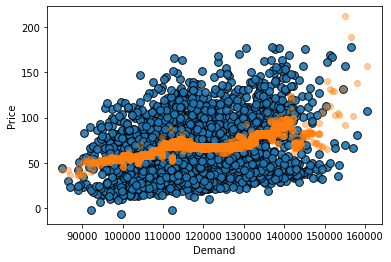

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

# Fit model
# Energy Price Variables
df_PriceModel = df[['price', 'demand', 'day_of_week']]

# Remove rows that have at least one missing value
df_PriceModel = df_PriceModel.dropna(axis=0)

PriceModel = GradientBoostingRegressor(random_state=22625)
PriceModel.fit(df_PriceModel[['demand', 'day_of_week']], df_PriceModel.price.to_frame())

# Predictions
predictions_PriceModel = PriceModel.predict(df_PriceModel[['demand', 'day_of_week']])
df_PriceModel['predictions'] = predictions_PriceModel

# Plot predictions
# Initialize layout
fig, ax = plt.subplots()

# Remove outliers
df_PriceModel = df_PriceModel[df_PriceModel.price < 179.49]

# Add scatterplot
ax.scatter(df_PriceModel.demand, df_PriceModel.price, s=60, alpha=0.9, edgecolors="k")
#ax.scatter(df.demand.values, y_hat, s=60, alpha=0.2, edgecolors="k")

# Plot regression line
ax.scatter(df_PriceModel.demand, df_PriceModel.predictions, alpha=0.4)
ax.set_xlabel('Demand')
ax.set_ylabel('Price')
plt.show()


# First Model: Positive Price with different polynomial grades in Demand Variable using Multilineal Regression Model

The no linear relationship between Energy's Price and its Demand brings the necesity to create new features and run models that try catch it. Thus, it is created a function that fit many Linear Regression Models with different Polynomial degree of Demand. The outcome function is a Pandas DataFrame with Root Mean Squeare Error [RMSE] train and test values for each model fitted. 

Linear Regression Model is selected in this case because it is possible catch no linear relationship by increasing the Polynomial Degree of independent variables.

Specifically, the function the following steps to create models:

1. Split data
2. Standarize variables and apply over them log10 numpy method
3. In a loop is repeat:
   1. Generate different polynomial grades of demand variables
   2. Fit models
   3. Get predictions
   4. Evaluate using Root Mean Squared Errors [RMSE]
   5. Store main information

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
from itertools import product

def create_prices_models(df, to_the_degree):
    """
    Create a Linear Regression Models to modelate energy's price with demand variable.
    Following:
    1. Split data
    2. Standarize variables and apply over them log10 numpy method
    3. Generate different polynomial grades of demand variables
    4. Fit models
    5. Get predictions
    6. Evaluate using Root Mean Squared Errors [RMSE]
    7. Store main information
    
    Args:
        df: data frame with Demand Energy's price variable. 
            The names must be "demand" and "price"
        to_the_degree: int that control the degree parameter in PolynomialFeatures() class.
            And it also control the number of models to be fitted. So if to_the_degree = 3
            then three Linear Regression Models [LRM] will be fitted:
                - LRM with degree 1
                - LRM with degree 2
                - LRM with degree 3

    Returns:
        Pandas.DataFrame: DataFrame with RMSE train and test values for each model fitted.
    """
    
    # Inputs
    df_no_neg_prices = df[df.price >= 0]
    df_X = pd.DataFrame(df_no_neg_prices['demand'])
    df_y = pd.DataFrame(df_no_neg_prices['price'])
    degrees = [i + 1 for i in range(to_the_degree)]
    biasses = [True, False]
    intercepts = [True, False]
    demands = ['demand', 'demandStandardized', 'demandLog10']
    prices = ['price', 'priceStandardized', 'priceLog10']
    combinations = list(product(biasses, intercepts, demands, prices))

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(df_X,
                                                        df_y, test_size=0.4, random_state=2256)

    # Standardize demand and price
    standardizer = StandardScaler()
    X_train['demandStandardized'] = standardizer.fit_transform(X_train.demand.values.reshape(-1,1))
    y_train['priceStandardized'] = standardizer.fit_transform(y_train.price.values.reshape(-1,1))
    X_test['demandStandardized'] = standardizer.fit_transform(X_test.demand.values.reshape(-1,1))
    y_test['priceStandardized'] = standardizer.fit_transform(y_test.price.values.reshape(-1,1))

    # Apply logarithm to the demand variable
    X_train['demandLog10'] = np.log10(df.demand)
    y_train['priceLog10'] = np.log10(df.price)
    X_test['demandLog10'] = np.log10(df.demand)
    y_test['priceLog10'] = np.log10(df.price)
    combinations = list(product(biasses, intercepts, demands, prices))
    
    # Get main information
    print('Fitting models ...')
    df_summary = pd.DataFrame()
    for comb in combinations:
        for degree in degrees:

            # Crete new variables with different grades of demandStandardized variable
            polyfeatures = PolynomialFeatures(degree=degree, include_bias=comb[0])
            X_demand_train = polyfeatures.fit_transform(np.array(X_train[comb[2]]).reshape(-1, 1))
            X_demand_test = polyfeatures.fit_transform(np.array(X_test[comb[2]]).reshape(-1, 1))

            try:
                # Fit model
                model_train = LinearRegression(fit_intercept=comb[1])
                model_train.fit(X_demand_train, y_train[comb[3]])

                # Predictions
                # Train
                predictions_train = model_train.predict(X_demand_train)
                # Test
                predictions_test = model_train.predict(X_demand_test)

                # Evaluate model
                rmse_train = MSE(y_train[comb[3]], predictions_train, squared=False)
                rmse_test = MSE(y_test[comb[3]], predictions_test, squared=False)
                # print('Train RMSE: {} and Test RMSE: {}'.format(rmse_train, rmse_test))

                # Store main data
                df_summary = pd.concat([df_summary,
                                        pd.DataFrame({'Grades':degree,
                                                      'Biasses':comb[0],
                                                      'Intercepts':comb[1],
                                                      'Demand':comb[2],
                                                      'Price':comb[3],
                                                      'Train_RMSE': rmse_train,
                                                      'Test_RMSE': rmse_test}, index=[0])])

            except:
                df_summary = pd.concat([df_summary,
                                        pd.DataFrame({'Grades':degree,
                                                      'Biasses':comb[0],
                                                      'Intercepts':comb[1],
                                                      'Demand':comb[2],
                                                      'Price':comb[3],
                                                      'Train_RMSE':np.nan,
                                                      'Test_RMSE':np.nan},
                                                    index=[0])])
                pass

    # Return
    print('Models fitted')
    return df_summary

It is created **360 models**!!!

In [17]:
# Creating models!!!
models = create_prices_models(df, 10)
models.shape

Fitting models ...
Models fitted


(360, 7)

So the winner model is which have the lowest RMSE in test settings. The top 10 models with lowest RMSE test values are:

In [18]:
top10_models_price = models.sort_values(by='Test_RMSE').iloc[:10,:]
top10_models_price.index = [i + 1 for i in range(10)]
top10_models_price

,Grades,Biasses,Intercepts,Demand,Price,Train_RMSE,Test_RMSE
1,7,False,True,demandStandardized,priceLog10,0.238928,0.249669
2,7,True,True,demandStandardized,priceLog10,0.238928,0.249669
3,7,True,False,demandStandardized,priceLog10,0.238928,0.249669
4,4,True,False,demandStandardized,priceLog10,0.239069,0.249792
5,4,False,True,demandStandardized,priceLog10,0.239069,0.249792
6,4,True,True,demandStandardized,priceLog10,0.239069,0.249792
7,6,True,True,demandStandardized,priceLog10,0.238994,0.249801
8,6,False,True,demandStandardized,priceLog10,0.238994,0.249801
9,6,True,False,demandStandardized,priceLog10,0.238994,0.249801
10,5,False,True,demandStandardized,priceLog10,0.239015,0.249870


The winning model is then fitted to all data [excluding three negative prices] for later use, and the model's predictions are plotted. It is observed that the predictions [orange points] fit the cloud points very well.

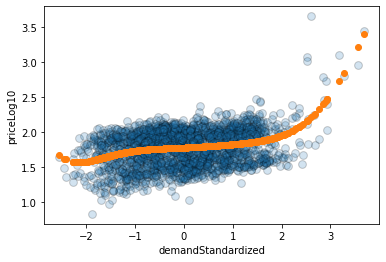

In [19]:
# Standardize demand and price
df_price_demand_model = df[df.price >= 0]
standardizer = StandardScaler()
df_price_demand_model['demandStandardized'] = standardizer.fit_transform(df_price_demand_model.demand.values.reshape(-1,1))

# Apply logarithm to the demand variable
df_price_demand_model['priceLog10'] = np.log10(df_price_demand_model.price)

# Third fit polinomial model
# Crete new variables with different grades of demandStandardized variable
polyfeatures = PolynomialFeatures(degree=7, include_bias=False)
X_demand = polyfeatures.fit_transform(np.array(df_price_demand_model.demandStandardized.values).reshape(-1, 1))
EnergyPriceModel = LinearRegression(fit_intercept=True)
EnergyPriceModel.fit(X_demand, df_price_demand_model.priceLog10)
predictions = EnergyPriceModel.predict(X_demand)

# Plot predictions
# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(df_price_demand_model.demandStandardized, df_price_demand_model.priceLog10, s=60, alpha=0.2, edgecolors="k")
#ax.scatter(df.demand.values, y_hat, s=60, alpha=0.2, edgecolors="k")

# Plot regression line
ax.scatter(df_price_demand_model.demandStandardized, predictions)
ax.set_xlabel('demandStandardized')
ax.set_ylabel('priceLog10')
plt.show()

### EnergyDemand Function

The demand can depend on the minimum and maximum temperature, sun exposure, rain, school day, vacations or even periods of time such as months or days of the week. When the temperature is high, customers are likely to increase energy demand when they turn on their air conditioners. Perhaps when there is a lot of exposure to the sun, the client may have the same behavior described above. Another possibility is that when customers tend to leave the house or there are fewer people in a house, such as school days or vacations, customers demand less power. Finally, the behavior of demand may be a function of time periods, for example, customers may demand a greater amount of energy in the middle of a year than at the beginning or end of the year because June and July are months with low temperatures.

However, the data must be plot to see its nature. It was plotted the variable Demand with each variables:

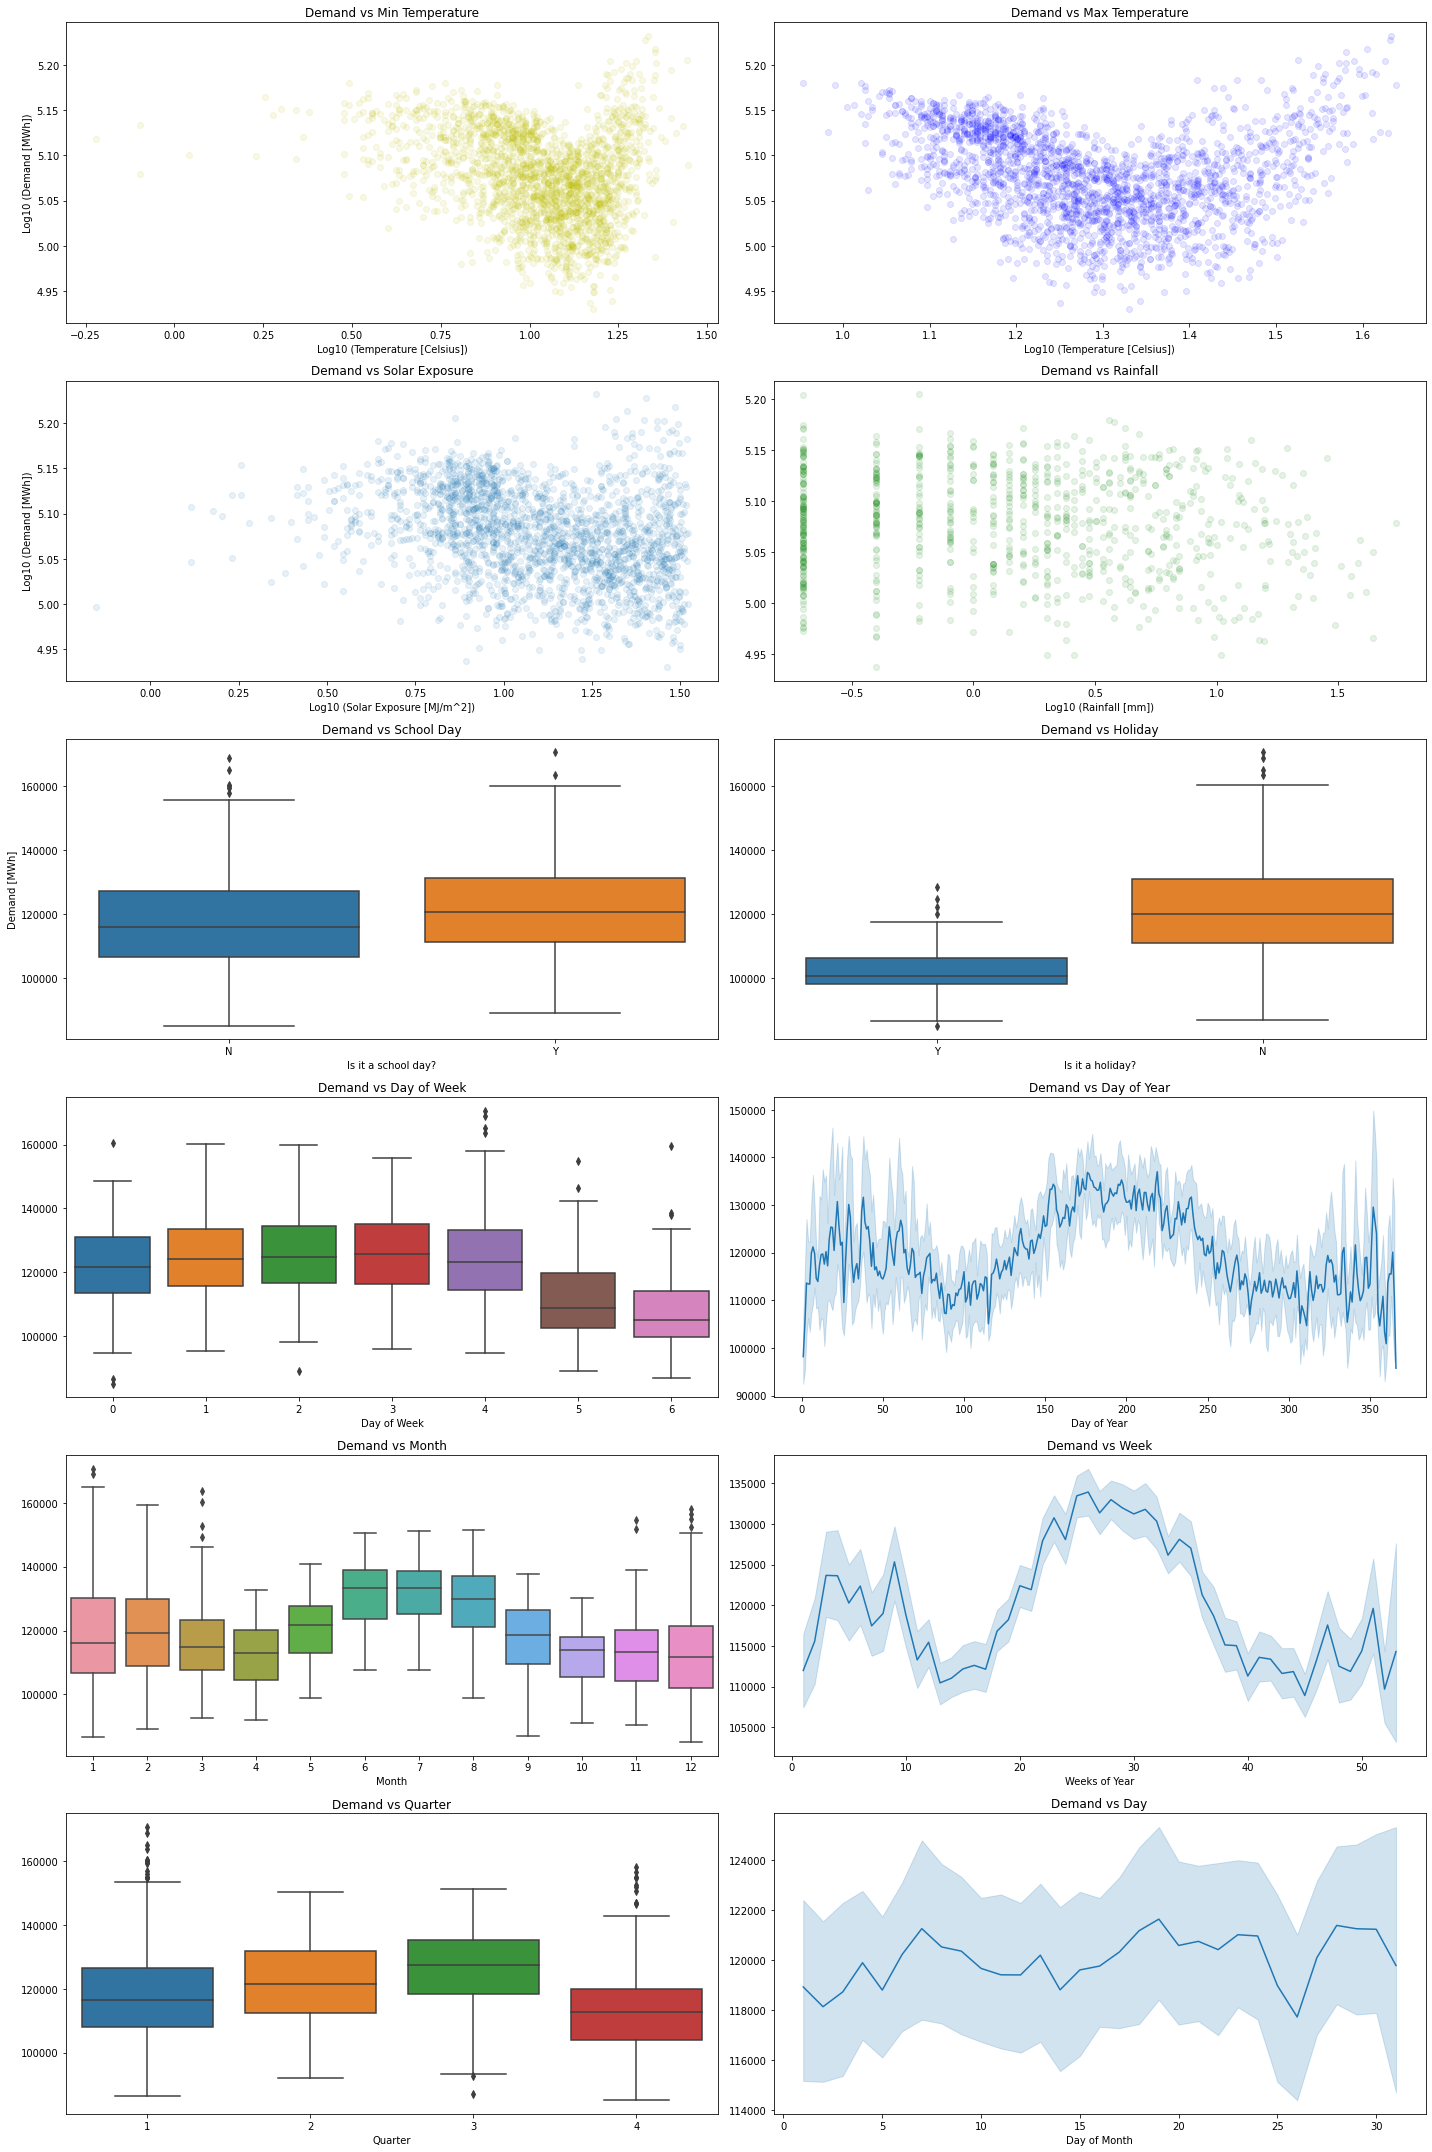

In [20]:
# Transform variables
df['min_temperatureStandardized'] = standardizer.fit_transform(df.min_temperature.values.reshape(-1,1))
df['min_temperatureLog10'] = np.log10(df.min_temperature)
df['max_temperatureStandardized'] = standardizer.fit_transform(df.max_temperature.values.reshape(-1,1))
df['max_temperatureLog10'] = np.log10(df.max_temperature)
df['solar_exposureStandardized'] = standardizer.fit_transform(df.solar_exposure.values.reshape(-1,1))
df['solar_exposureLog10'] = np.log10(df.solar_exposure)
df['rainfallStandardized'] = standardizer.fit_transform(df.rainfall.values.reshape(-1,1))
df['rainfallLog10'] = np.log10(df.rainfall)

# Subplot with Seaborn and Matplotlib
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(6, 2, figsize=(20, 30))
# fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(36, 20))
ax1.scatter(df.min_temperatureLog10, df.demandLog10, alpha=0.1, c='y')
ax1.set_title('Demand vs Min Temperature')
ax1.set(xlabel='Log10 (Temperature [Celsius])', ylabel='Log10 (Demand [MWh])')
ax2.scatter(df.max_temperatureLog10, df.demandLog10, alpha=0.1, c='b')
ax2.set_title('Demand vs Max Temperature')
ax2.set(xlabel='Log10 (Temperature [Celsius])')
ax3.scatter(df.solar_exposureLog10, df.demandLog10, alpha=0.1)
ax3.set_title('Demand vs Solar Exposure')
ax3.set(xlabel='Log10 (Solar Exposure [MJ/m^2])', ylabel='Log10 (Demand [MWh])')
ax4.scatter(df.rainfallLog10, df.demandLog10, alpha=0.1, c='g')
ax4.set_title('Demand vs Rainfall')
ax4.set(xlabel='Log10 (Rainfall [mm])')
# ax5.boxplot([df[df.school_day == 'N'].demand, df[df.school_day == 'Y'].demand], patch_artist=True)
sns.boxplot(x='school_day', y='demand', data=df, ax=ax5)
ax5.set_title('Demand vs School Day')
ax5.set(xlabel='Is it a school day?', ylabel='Demand [MWh]')
# ax6.boxplot([df[df.holiday == 'N'].demand, df[df.holiday == 'Y'].demand], patch_artist=True)
sns.boxplot(x='holiday', y='demand', data=df, ax=ax6)
ax6.set_title('Demand vs Holiday')
ax6.set(xlabel='Is it a holiday?', ylabel='')
fig.tight_layout()
sns.boxplot(x='day_of_week', y='demand', data=df, ax=ax7)
ax7.set_title('Demand vs Day of Week')
ax7.set(xlabel='Day of Week', ylabel='')
fig.tight_layout()
sns.lineplot(x='day_of_year', y='demand', data=df, ax=ax8)
ax8.set_title('Demand vs Day of Year')
ax8.set(xlabel='Day of Year', ylabel='')
fig.tight_layout()
sns.boxplot(x='month', y='demand', data=df, ax=ax9)
ax9.set_title('Demand vs Month')
ax9.set(xlabel='Month', ylabel='')
fig.tight_layout()
sns.lineplot(x='week', y='demand', data=df, ax=ax10)
ax10.set_title('Demand vs Week')
ax10.set(xlabel='Weeks of Year', ylabel='')
fig.tight_layout()
sns.boxplot(x='quarter', y='demand', data=df, ax=ax11)
ax11.set_title('Demand vs Quarter')
ax11.set(xlabel='Quarter', ylabel='')
fig.tight_layout()
sns.lineplot(x='day', y='demand', data=df, ax=ax12)
ax12.set_title('Demand vs Day')
ax12.set(xlabel='Day of Month', ylabel='')
fig.tight_layout()

The graph of results was gorgeus. There are relationships that were expected but others are not clear.

Demand and temperature do not have a linear relationship. When the minimum temperature of a day is low, the energy demand increases, but the extremely low minimum temperatures does not quickly increase the demand, they tend to reach a certain level and then decreases. When the minimum temperature of a day is high, the energy demand always increases. With the maximum temperature of a day, the behavior of the relationship with the energy demand tends to increase with the lower and higher values.

Rainfall and energy demand are not related, it is clear how the energy demand does not vary when the mm of rain fell in a day increase. Another unrelated scenario is presented with the school day, no difference is observed between both boxplots.

Then, it is observed that there is a relationship between the vacation variables and energy demand. When a day is a holiday, families tend to demand less energy than regular days. It can be explained because this days families tend to leave home and enjoying activities that require little energy such as visiting natural spaces [beaches, forests, etc.] or going out to unnatural public places [parks, mall, etc].

The Periods of time play a important rol in the Behavior of the Energy Demand. Customers tend to demand less energy on weekends than on weekdays; day of year, months, week numer and quarter show that the demand is higher in June and July, at the middle of the year than the rest of the year. The period of time: *day of a month* does not have a clear pattern, however it is courious that the demand decrease quickly from day 24 to day 26.

Finally, Solar exposure and energy demand do not have a clear relationship. It is a kind of non-linear relationship, when the extremely low values of the exposure decrease [from 0.50 (Log10 MJ/mˆ2) ], the demand decreases. Probably for exposure values higher than 0.50, the behavior of the demand is not evident, it can remain at an energy value or it can decrease to a certain level and then be constant. This relationship is shown below using other variables for clarification.

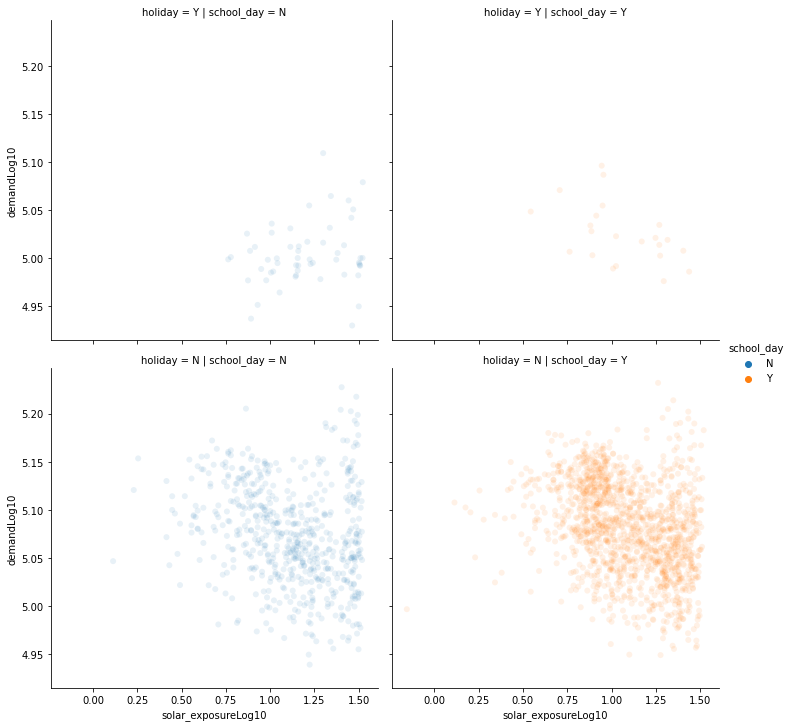

In [21]:
sns.relplot(data=df[df.price > 0], 
            y='demandLog10', 
            x='solar_exposureLog10',
            hue='school_day',
            col='school_day',
            row='holiday',
           alpha=0.1)

The same unclear relationship is observed when the day is not a holiday and whatever the value of the school day. Apparently the relationship is different from what has been seen so far when the day is a holiday. Around non-school days when exposure increases, demand decreases but there is a clear negative relationship when the days are also school days.

The no linearity relationship between Energy Demand and some variables like Maximum Temperature and the changes in the relationship between Demand and Solar Exposure when it interact with holiday and school_day variables requiere a model that take into account all this complexities. Altought linear models can handle them using spline transformation however reach out of this analysis. So, **Gradiente Boosting Regression [GBR]** with decision trees is a right choice that allow no just catch no linear association between predictor and target variables but also interactions between predictor variables without do effort of generating transformations by polynomial/spline preproccesing technics before to estimate the model.

It is fitted a **GBR model** for each combination of predictor **'min_temperature', 'max_temperature', 'rainfall', 'solar_exposure', 'school_day', 'holiday', 'days of week', 'days of year', 'months', 'weeks in a year', 'quarter' and 'days in a month'**. That is, a GBR model for min_temperature, then GBR model for max_temperature, ..., then GBR model for min_temperature and rainfall, then GBR model for min_temperature and holiday, ..., to GBR model for all demand predictor variables. There are 8191 total combinations. For each model estimation was stored main information: *RMSE_train* and *RMSE_Test* as was done with Price Function.

It is created 4095 models!!!

The energy demand model with predictors **'min_temperature, max_temperature, solar_exposure, holiday, day_of_week, day_of_year, month, week, quarter, year'** was the best, it has the lowest test RMSE value *0.340257*. However, in order to avoid looking for data that is not found in the given data [it is necessary to look up which days in Australia are public holidays] and keep the model simple, the model that will represent the Energy Demand function is the one with the predictors **'min_temperature, max_temperature, solar_exposure, day_of_week, day_of_year, week, quarter, year'** . This model also performs well with unseen data: *0.376999* for Test RMSE.

Using data without transformation

RMSE Train:  4172.10951929289

RMSE Test:  4953.7178486787525

The selected demand model is fitted for use below and some predictions were drawn to observe its performance. It is observed that when the demand with maximum temperature is plotted, the model captures both the non-linear relationship as well as the dispersion between points [orange points are prediction made by model].

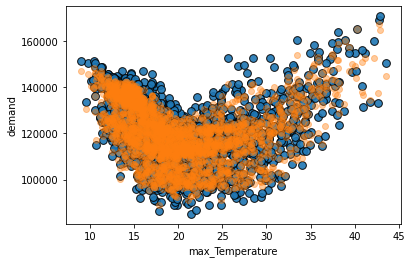

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

# Fit model
# Select variables and remove observations with price negative
demand_predictor_vbles = ['min_temperature', 'max_temperature', 'solar_exposure', 'holiday', 'day_of_week', 'day_of_year', 'month', 'week', 'quarter', 'year']
demand_model_vbles = ['demand'] + demand_predictor_vbles
df_DemandModel = df[demand_model_vbles]

# Remove rows that have at least one missing value
df_DemandModel = df_DemandModel.dropna(axis=0)

# Transform object variable to numeric
df_DemandModel['holiday'] = df_DemandModel['holiday'].apply(lambda x: 1 if x == 'Y' else 0)

DemandModel = GradientBoostingRegressor(random_state=22625)
DemandModel.fit(df_DemandModel[demand_predictor_vbles], df_DemandModel.demand.to_frame())

# Predictions
predictions_DemandModel = DemandModel.predict(df_DemandModel[demand_predictor_vbles])
df_DemandModel['predictions'] = predictions_DemandModel

# Plot predictions
# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(df_DemandModel.max_temperature, df_DemandModel.demand, s=60, alpha=0.9, edgecolors="k")
#ax.scatter(df.demand.values, y_hat, s=60, alpha=0.2, edgecolors="k")

# Plot regression line
ax.scatter(df_DemandModel.max_temperature, df_DemandModel.predictions, alpha=0.4)
ax.set_xlabel('max_Temperature')
ax.set_ylabel('demand')
plt.show()


### Min and Max Temperature and Solar Exposure Functions

Min, max temperature and solar exposure variables have no lineal relationship with variables from time periods. For example they have the same seasonal behavior and looks like a senosoidal function. The lowest values it is presented at middle of the year and the higher vales are at the beging and end of the year

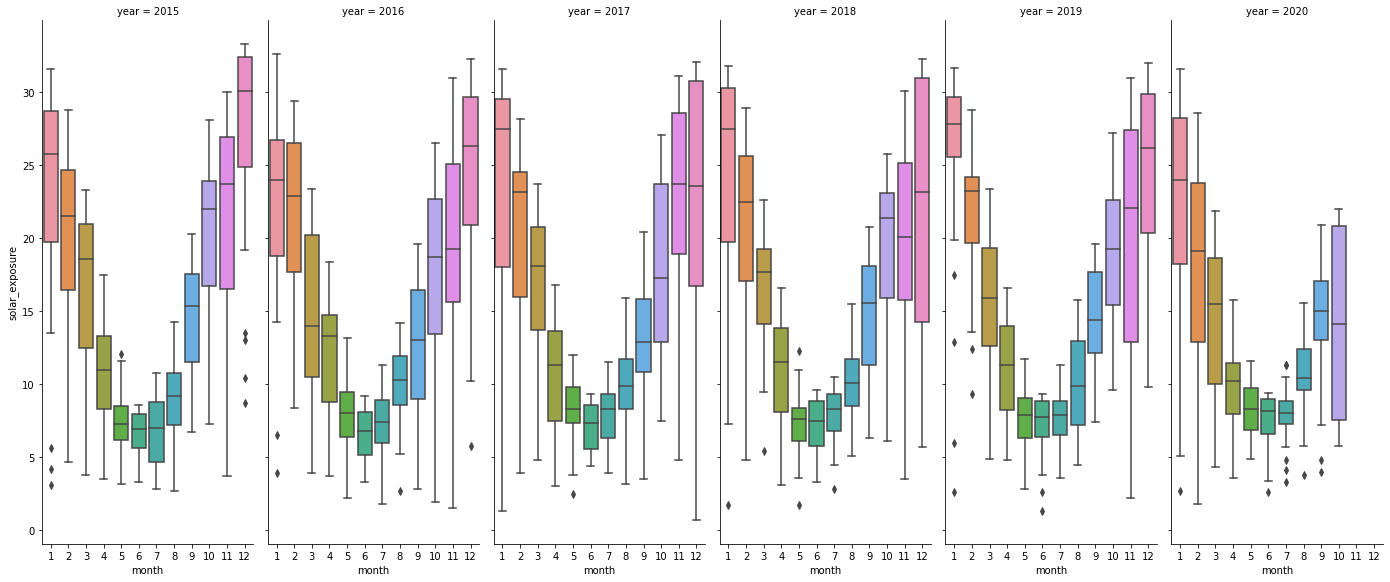

In [ ]:
# plot
sns.catplot(x='month', y='solar_exposure', col='year', kind='box', data=df, height=8, aspect=.4)
plt.show()

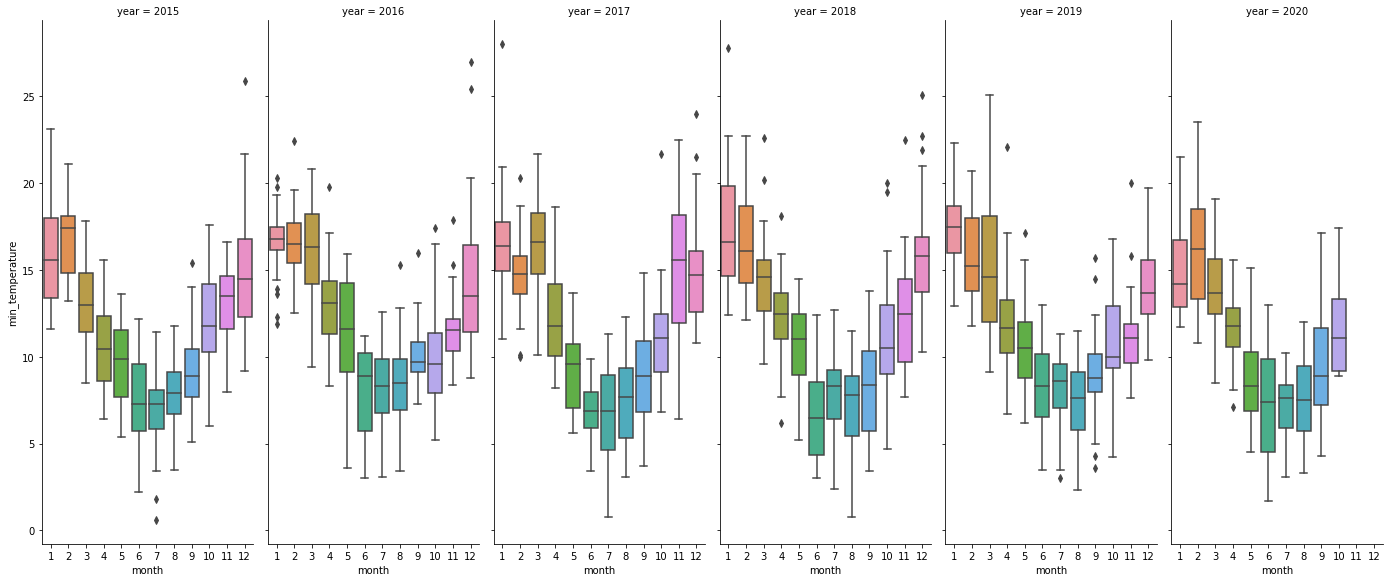

In [ ]:
sns.catplot(x='month', y='min_temperature', col='year', kind='box', data=df, height=8, aspect=.4)
plt.show()

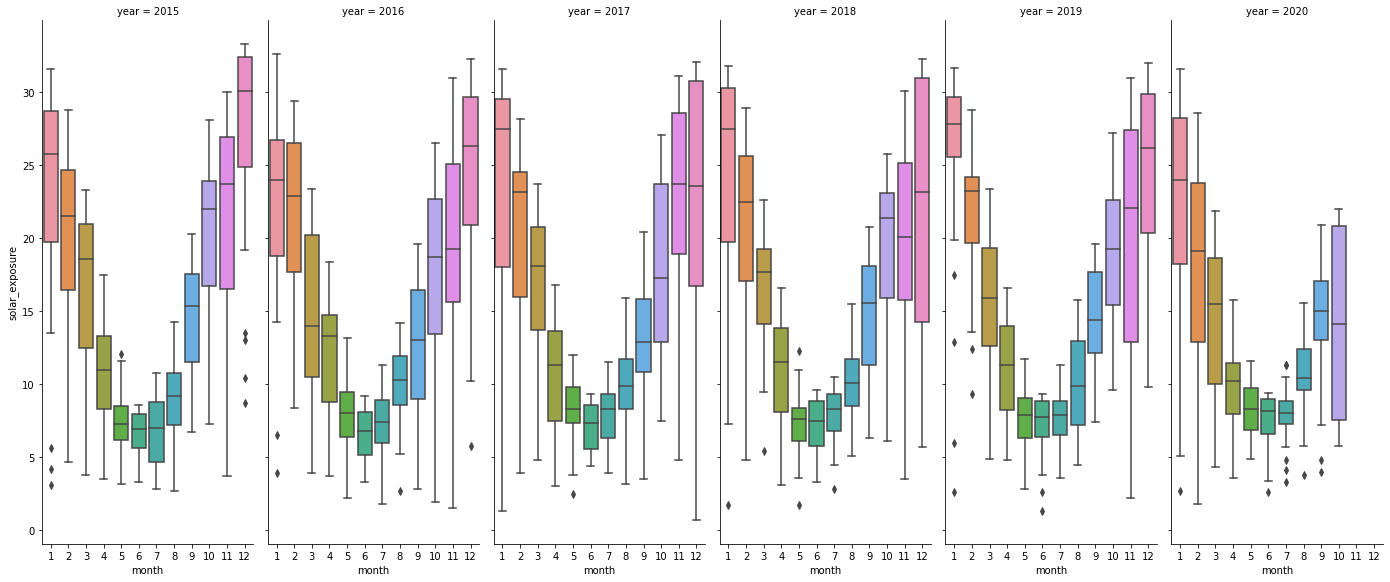

In [ ]:
sns.catplot(x='month', y='solar_exposure', col='year', kind='box', data=df, height=8, aspect=.4)
plt.show()

## Min Temperature Function

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import itertools

def create_mintemp_models(df):
    """
    Create a Gradient Boosting Model for each predictors combination.
    
    input: a pandas.DataFrame object with variables related to Energy Demand Function
    output: a pandas.DataFrame object with the main information about each model [RMSE_Train and RMSE_Test]
    """
    
    # Energy Demand Variables
    mintemp_vbles = ['min_temperature', 'day_of_week', 'day_of_year', 'month', 'week', 'quarter', 'day', 'year']
    
    # Select variables
    df_weather_mintemp = df[mintemp_vbles]
    
    # Remove rows that have at least one missing value
    df_weather_mintemp = df_weather_mintemp.dropna(axis=0)
    
    # Split data
    y_train, y_test = df_weather_mintemp['min_temperature'][(df_weather_mintemp.year <= 2019) & ((df_weather_mintemp.year <= 2019) & (df_weather_mintemp.month <= 10))], df_weather_mintemp['min_temperature'][(df_weather_mintemp.year > 2019) | ((df_weather_mintemp.year >= 2019) & (df_weather_mintemp.month > 10))]
    X_train, X_test = pd.DataFrame(df_weather_mintemp.drop('min_temperature', axis=1))[(df_weather_mintemp.year <= 2019) & ((df_weather_mintemp.year <= 2019) & (df_weather_mintemp.month <= 10))], pd.DataFrame(df_weather_mintemp.drop('min_temperature', axis=1))[(df_weather_mintemp.year > 2019) | ((df_weather_mintemp.year >= 2019) & (df_weather_mintemp.month > 10))]
    
    # All X varibles combinations
    list_all_comb = []
    for L in range(0, len(mintemp_vbles[1:])+1):
        for subset in itertools.combinations(mintemp_vbles[1:], L):
            if len(list(subset)) > 0:
                list_all_comb.append(list(subset))
                             
    # Get main information
    print('Length list_all_comb object: ', len(list_all_comb))
    print('Fitting models ...')
    df_summary = pd.DataFrame()
    for comb in list_all_comb:
        # Fit model
        model_train = GradientBoostingRegressor(random_state=2279)
        model_train.fit(X_train[comb], y_train)
        
        # Predictions
        # Train
        predictions_train = model_train.predict(X_train[comb])
        # Test
        predictions_test = model_train.predict(X_test[comb])

        # Evaluate model
        rmse_train = MSE(y_train, predictions_train, squared=False)
        rmse_test = MSE(y_test, predictions_test, squared=False)
        
        # Store main data
        df_summary = pd.concat([df_summary,
                                pd.DataFrame({'Predictor_Vbls': ', '.join(comb),
                                              'Num_Vbls': len(comb),
                                              'Train_RMSE': rmse_train,
                                              'Test_RMSE': rmse_test}, index=[0])])
    print('All models was fitted!!!')
        
    return df_summary

In [ ]:
# Fitting min_temperature models!!!!
import time

t0 = time.time()
models_mintemp = create_mintemp_models(df)
t1 = time.time()
print('Time for create_rainfall_models() function: {} second [{} minutes]'.format(t1 - t0, round((t1 - t0)/60, 2)))
print('Amount of models fitted: ', models_mintemp.shape[0])

Length list_all_comb object:  127
Fitting models ...
All models was fitted!!!
Time for create_rainfall_models() function: 10.68898606300354 second [0.18 minutes]
Amount of models fitted:  127


In [ ]:
models_mintemp.sort_values(by='Test_RMSE')

,Predictor_Vbls,Num_Vbls,Train_RMSE,Test_RMSE
0,"day_of_week, week, quarter",3,2.563620,2.821007
0,"day_of_week, month, week, quarter",4,2.557153,2.822665
0,"week, quarter",2,2.606366,2.830544
0,"day_of_week, month, week",3,2.557153,2.830600
0,"month, week",2,2.596137,2.849373
...,...,...,...,...
0,"day_of_year, month, quarter, day",4,2.510220,4.747243
0,"day_of_year, month, day",3,2.510220,4.747243
0,"day_of_year, quarter, day",3,2.512231,4.772377
0,"day_of_week, day_of_year, quarter, day",4,2.460167,4.791052


In [ ]:
# Fitting winner model

# Fit model
# Select variables and remove observations with price negative
df_MintempModel = df[['min_temperature', 'day_of_week', 'week', 'quarter']]

# Remove rows that have at least one missing value
df_MintempModel = df_MintempModel.dropna(axis=0)

# Fitting
MintempModel = GradientBoostingRegressor(random_state=22625)
MintempModel.fit(df_MintempModel[['week', 'quarter']], df_MintempModel.min_temperature.to_frame())
type(MintempModel)

sklearn.ensemble._gb.GradientBoostingRegressor

## Max Temperature Function

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import itertools

def create_maxtemp_models(df):
    """
    Create a Gradient Boosting Model for each predictors combination.
    
    input: a pandas.DataFrame object with variables related to Energy Demand Function
    output: a pandas.DataFrame object with the main information about each model [RMSE_Train and RMSE_Test]
    """
    
    # Energy Demand Variables
    maxtemp_vbles = ['max_temperature', 'day_of_week', 'day_of_year', 'month', 'week', 'quarter', 'day', 'year']
    
    # Select variables
    df_weather_maxtemp = df[maxtemp_vbles]
    
    # Remove rows that have at least one missing value
    df_weather_maxtemp = df_weather_maxtemp.dropna(axis=0)
    
    # Split data
    y_train, y_test = df_weather_maxtemp['max_temperature'][(df_weather_maxtemp.year <= 2019) & ((df_weather_maxtemp.year <= 2019) & (df_weather_maxtemp.month <= 10))], df_weather_maxtemp['max_temperature'][(df_weather_maxtemp.year > 2019) | ((df_weather_maxtemp.year >= 2019) & (df_weather_maxtemp.month > 10))]
    X_train, X_test = pd.DataFrame(df_weather_maxtemp.drop('max_temperature', axis=1))[(df_weather_maxtemp.year <= 2019) & ((df_weather_maxtemp.year <= 2019) & (df_weather_maxtemp.month <= 10))], pd.DataFrame(df_weather_maxtemp.drop('max_temperature', axis=1))[(df_weather_maxtemp.year > 2019) | ((df_weather_maxtemp.year >= 2019) & (df_weather_maxtemp.month > 10))]
    
    # All X varibles combinations
    list_all_comb = []
    for L in range(0, len(maxtemp_vbles[1:])+1):
        for subset in itertools.combinations(maxtemp_vbles[1:], L):
            if len(list(subset)) > 0:
                list_all_comb.append(list(subset))
                             
    # Get main information
    print('Length list_all_comb object: ', len(list_all_comb))
    print('Fitting models ...')
    df_summary = pd.DataFrame()
    for comb in list_all_comb:
        # Fit model
        model_train = GradientBoostingRegressor(random_state=2279)
        model_train.fit(X_train[comb], y_train)
        
        # Predictions
        # Train
        predictions_train = model_train.predict(X_train[comb])
        # Test
        predictions_test = model_train.predict(X_test[comb])

        # Evaluate model
        rmse_train = MSE(y_train, predictions_train, squared=False)
        rmse_test = MSE(y_test, predictions_test, squared=False)
        
        # Store main data
        df_summary = pd.concat([df_summary,
                                pd.DataFrame({'Predictor_Vbls': ', '.join(comb),
                                              'Num_Vbls': len(comb),
                                              'Train_RMSE': rmse_train,
                                              'Test_RMSE': rmse_test}, index=[0])])
    print('All models was fitted!!!')
        
    return df_summary

In [ ]:
# Fitting max_temperature models!!!!

t0 = time.time()
models_maxtemp = create_maxtemp_models(df)
t1 = time.time()
print('Time for create_rainfall_models() function: {} second [{} minutes]'.format(t1 - t0, round((t1 - t0)/60, 2)))
print('Amount of models fitted: ', models_maxtemp.shape[0])

Length list_all_comb object:  127
Fitting models ...
All models was fitted!!!
Time for create_rainfall_models() function: 10.671775102615356 second [0.18 minutes]
Amount of models fitted:  127


In [ ]:
models_maxtemp.sort_values(by='Test_RMSE')

,Predictor_Vbls,Num_Vbls,Train_RMSE,Test_RMSE
0,"month, week",2,3.895119,4.624856
0,"month, week, quarter",3,3.895119,4.627993
0,"week, quarter",2,3.898236,4.629255
0,"day_of_week, month, quarter",3,4.005968,4.663834
0,"day_of_week, month",2,4.005968,4.663834
...,...,...,...,...
0,year,1,6.072394,6.190561
0,"day_of_week, day",2,5.955524,6.236238
0,day,1,6.043477,6.256277
0,"day_of_week, day, year",3,5.885936,6.287853


In [ ]:
# Fitting winner model

# Fit model
# Select variables and remove observations with price negative
df_MaxtempModel = df[['max_temperature', 'week', 'month']]

# Take log10 over numeric data
df_MaxtempModel['max_temperature'] = np.log10(df_MaxtempModel.max_temperature)

# Remove rows that have at least one missing value
df_MaxtempModel = df_MaxtempModel.dropna(axis=0)

# Fitting
MaxtempModel = GradientBoostingRegressor(random_state=22625)
MaxtempModel.fit(df_MaxtempModel[['week', 'month']], df_MaxtempModel.max_temperature.to_frame())
type(MaxtempModel)

sklearn.ensemble._gb.GradientBoostingRegressor

# Solar Exposure Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import itertools

def create_solar_models(df):
    """
    Create a Gradient Boosting Model for each predictors combination.
    
    input: a pandas.DataFrame object with variables related to Energy Demand Function
    output: a pandas.DataFrame object with the main information about each model [RMSE_Train and RMSE_Test]
    """
    
    # Energy Demand Variables
    solar_vbles = ['solar_exposure', 'day_of_week', 'day_of_year', 'month', 'week', 'quarter', 'day', 'year']
    
    # Select variables
    df_weather_solar = df[solar_vbles]
    
    # Remove rows that have at least one missing value
    df_weather_solar = df_weather_solar.dropna(axis=0)
    
    # Split data
    y_train, y_test = df_weather_solar['solar_exposure'][(df_weather_solar.year <= 2019) & ((df_weather_solar.year <= 2019) & (df_weather_solar.month <= 10))], df_weather_solar['solar_exposure'][(df_weather_solar.year > 2019) | ((df_weather_solar.year >= 2019) & (df_weather_solar.month > 10))]
    X_train, X_test = pd.DataFrame(df_weather_solar.drop('solar_exposure', axis=1))[(df_weather_solar.year <= 2019) & ((df_weather_solar.year <= 2019) & (df_weather_solar.month <= 10))], pd.DataFrame(df_weather_solar.drop('solar_exposure', axis=1))[(df_weather_solar.year > 2019) | ((df_weather_solar.year >= 2019) & (df_weather_solar.month > 10))]
    
    # All X varibles combinations
    list_all_comb = []
    for L in range(0, len(solar_vbles[1:])+1):
        for subset in itertools.combinations(solar_vbles[1:], L):
            if len(list(subset)) > 0:
                list_all_comb.append(list(subset))
                             
    # Get main information
    print('Length list_all_comb object: ', len(list_all_comb))
    print('Fitting models ...')
    df_summary = pd.DataFrame()
    for comb in list_all_comb:
        # Fit model
        model_train = GradientBoostingRegressor(random_state=2279)
        model_train.fit(X_train[comb], y_train)
        
        # Predictions
        # Train
        predictions_train = model_train.predict(X_train[comb])
        # Test
        predictions_test = model_train.predict(X_test[comb])

        # Evaluate model
        rmse_train = MSE(y_train, predictions_train, squared=False)
        rmse_test = MSE(y_test, predictions_test, squared=False)
        
        # Store main data
        df_summary = pd.concat([df_summary,
                                pd.DataFrame({'Predictor_Vbls': ', '.join(comb),
                                              'Num_Vbls': len(comb),
                                              'Train_RMSE': rmse_train,
                                              'Test_RMSE': rmse_test}, index=[0])])
    print('All models was fitted!!!')
        
    return df_summary

In [ ]:
# Fitting solar_exposure models!!!!

t0 = time.time()
models_solar = create_solar_models(df)
t1 = time.time()
print('Time for create_solar_models() function: {} second [{} minutes]'.format(t1 - t0, round((t1 - t0)/60, 2)))
print('Amount of models fitted: ', models_solar.shape[0])

Length list_all_comb object:  127
Fitting models ...
All models was fitted!!!
Time for create_solar_models() function: 10.769219636917114 second [0.18 minutes]
Amount of models fitted:  127


In [ ]:
models_solar.sort_values(by='Test_RMSE')

,Predictor_Vbls,Num_Vbls,Train_RMSE,Test_RMSE
0,"day_of_week, day_of_year, quarter, year",4,3.860250,5.540987
0,"day_of_week, day_of_year, year",3,3.883130,5.545924
0,"day_of_week, day_of_year",2,3.942211,5.566887
0,"day_of_week, month, quarter, day",4,4.092382,5.578277
0,"day_of_week, month, day",3,4.092382,5.578277
...,...,...,...,...
0,"day, year",2,7.218564,7.781183
0,"day_of_week, day",2,7.160261,7.790159
0,day_of_week,1,7.288099,7.790431
0,"day_of_week, day, year",3,7.126353,7.808075


In [ ]:
# Fitting winner model

# Fit model
# Select variables and remove observations with price negative
df_SolarModel = df[['solar_exposure', 'day_of_week', 'day_of_year', 'quarter', 'year']]

# Remove rows that have at least one missing value
df_SolarModel = df_SolarModel.dropna(axis=0)

# Fitting
SolarModel = GradientBoostingRegressor(random_state=22625)
SolarModel.fit(df_SolarModel[['quarter', 'day_of_week', 'day_of_year', 'quarter', 'year']], df_SolarModel.solar_exposure.to_frame())
type(SolarModel)

sklearn.ensemble._gb.GradientBoostingRegressor

# Energy Price Forecast Function

In [ ]:
import datetime
def EnergyPriceForecast(dates):
    """
    Input (list): list with dates in string format: ['2022-07-11', '2022-09-12']
    """
    
    # Create time periods variables
    df = pd.DataFrame()
    df['date'] = dates
    df['date'] = df.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    df['week'] = [ts.week for ts in df.date]
    df['month'] = [ts.month for ts in df.date]
    df['quarter'] = [ts.quarter for ts in df.date]
    df['day_of_year'] = [ts.day_of_year for ts in df.date]
    df['year'] = [ts.year for ts in df.date]
    df['day_of_week'] = [ts.day_of_week for ts in df.date]
    
    # Predict Min Temperature
    pred_MinTemp = MintempModel.predict(df[['week', 'quarter']])
    
    # Predict Max Temperature
    pred_MaxTemp = MaxtempModel.predict(df[['week', 'month']])
    
    # Predict Solar Exposure
    pred_Solar = SolarModel.predict(df[['quarter', 'month']])
    
    # Add Min and Max Temperature to df
    df['min_temperature'] = pred_MinTemp
    df['max_temperature'] = pred_MaxTemp
    df['solar_exposure'] = pred_Solar
    
    # Predict Energy Demand
    pred_Demand = DemandModel.predict(df[['min_temperature', 'max_temperature', 'solar_exposure', 'day_of_week', 'day_of_year', 'week', 'quarter', 'year']])
    # Add Demand to df
    df['demand'] = pred_Demand
    
    # Predict Energy Price
    # Third fit polinomial model
    # Crete new variables with different grades of demandStandardized variable
    polyfeatures = PolynomialFeatures(degree=7, include_bias=False)
    X_demand = polyfeatures.fit_transform(np.array(df.demand.values).reshape(-1, 1))
    # predPrice = EnergyPriceModel.predict(df['demand'].values.reshape(-1, 1))
    pred_Price = EnergyPriceModel.predict(X_demand)
    
    # Return
    return pred_MinTemp, pred_MaxTemp, pred_Demand, pred_Price

In [ ]:
# Evaluate Forecast Energy Price

from sklearn.metrics import mean_squared_error as MSE

dates = [date.date().isoformat() for date in df.date]
pred_MinTemp, pred_MaxTemp, pred_Demand, pred_Price = EnergyPriceForecast(dates)
nonan_pricelog10 = df.priceLog10[~ df.priceLog10.isnull()].index.tolist()
pred_PriceLog10 = pred_Price[nonan_pricelog10]
PriceLog10 = df.priceLog10.values[nonan_pricelog10]
rmse_pricelog10 = MSE(PriceLog10, pred_PriceLog10, squared=False)
rmse_pricelog10

0.2616471666112769

In [ ]:
# Plot Energy Price Forecast model
df_foremodel = pd.DataFrame({'priceLog10':PriceLog10, 'pred_priceLog10':pred_PriceLog10})
df_foremodel['price'] = [10 ** price for price in df_foremodel.priceLog10]
df_foremodel['pred_price'] = [10 ** price for price in df_foremodel.pred_priceLog10]

<AxesSubplot:>

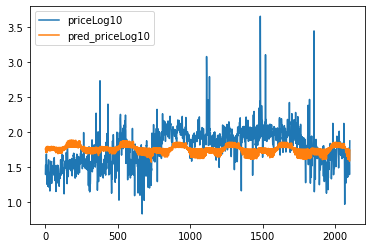

In [ ]:
df_foremodel[['priceLog10','pred_priceLog10']].plot()